# Project Title
### Data Engineering Capstone Project

#### Project Summary
--describe your project at a high level--

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [2]:
# Do all imports and installs here
from pyspark.sql import SparkSession
from pyspark.sql.types import FloatType, IntegerType, TimestampType
from pyspark.sql.functions import *
import pyspark.sql.functions as F
from immigration_codes import country_udf
from city_code import city_code_udf,city_codes
from abbrev_state import abbrev_state_udf, abbrev_state_list
from visa_type import visa_code_udf, visa_code
import pyspark.sql.types as T
import datetime

#Build spark session
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = "/opt/conda/bin:/opt/spark-2.4.3-bin-hadoop2.7/bin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/lib/jvm/java-8-openjdk-amd64/bin"
os.environ["SPARK_HOME"] = "/opt/spark-2.4.3-bin-hadoop2.7"
os.environ["HADOOP_HOME"] = "/opt/spark-2.4.3-bin-hadoop2.7"
spark = SparkSession.builder\
        .config("spark.jars.repositories", "https://repos.spark-packages.org/")\
        .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:2.7.0,saurfang:spark-sas7bdat:2.0.0-s_2.11")\
        .enableHiveSupport().getOrCreate()

### Step 1: Scope the Project and Gather Data

#### Scope
- The project's scope will cover multiple source of data from CSV and SAS data set. 
- The project will mainly use Spark for data Extraction, Transformation and Load into parquet files and store into a location. 
- The Spark will be utilized because of its highly powerful process a big dataset and can be applied into such a various data format.

#### Describe and Gather Data 
- **I94 Immigration Data**: This data comes from the US National Tourism and Trade Office. A data dictionary is included in the workspace. [This is where the data comes from](https://travel.trade.gov/research/reports/i94/historical/2016.html). There's a sample file so you can take a look at the data in csv format before reading it all in. You do not have to use the entire dataset, just use what you need to accomplish the goal you set at the beginning of the project.
- **World Temperature Data**: This dataset came from Kaggle. [You can read more about it here](https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data).
- **U.S. City Demographic Data**: This data comes from OpenSoft. [You can read more about it here](https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/).
- **Airport Code Table**: This is a simple table of airport codes and corresponding cities. [It comes from here](https://datahub.io/core/airport-codes#data).

In [3]:
# Making parquet data for faster reading. The june data set has some additional columns then will be read separately and then union to the rest of months.  
immigration_dataset_no_jun = spark.read.format('com.github.saurfang.sas.spark').load("../../data/18-83510-I94-Data-2016/i94_jan16_sub.sas7bdat")\
                    .union(spark.read.format('com.github.saurfang.sas.spark').load("../../data/18-83510-I94-Data-2016/i94_feb16_sub.sas7bdat"))\
                    .union(spark.read.format('com.github.saurfang.sas.spark').load("../../data/18-83510-I94-Data-2016/i94_mar16_sub.sas7bdat"))\
                    .union(spark.read.format('com.github.saurfang.sas.spark').load("../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat"))\
                    .union(spark.read.format('com.github.saurfang.sas.spark').load("../../data/18-83510-I94-Data-2016/i94_may16_sub.sas7bdat"))\
                    .union(spark.read.format('com.github.saurfang.sas.spark').load("../../data/18-83510-I94-Data-2016/i94_jul16_sub.sas7bdat"))\
                    .union(spark.read.format('com.github.saurfang.sas.spark').load("../../data/18-83510-I94-Data-2016/i94_aug16_sub.sas7bdat"))\
                    .union(spark.read.format('com.github.saurfang.sas.spark').load("../../data/18-83510-I94-Data-2016/i94_sep16_sub.sas7bdat"))\
                    .union(spark.read.format('com.github.saurfang.sas.spark').load("../../data/18-83510-I94-Data-2016/i94_oct16_sub.sas7bdat"))\
                    .union(spark.read.format('com.github.saurfang.sas.spark').load("../../data/18-83510-I94-Data-2016/i94_nov16_sub.sas7bdat"))\
                    .union(spark.read.format('com.github.saurfang.sas.spark').load("../../data/18-83510-I94-Data-2016/i94_dec16_sub.sas7bdat"))
immigration_dataset_jun = spark.read.format('com.github.saurfang.sas.spark').load("../../data/18-83510-I94-Data-2016/i94_jun16_sub.sas7bdat")
raw_immigration_dataset = immigration_dataset_no_jun.union(immigration_dataset_jun.select(*immigration_dataset_no_jun.columns))
raw_immigration_dataset.write.mode("overwrite").parquet("input/i94_data")

In [3]:
# Read Parquet Immigration data 
raw_immigration_df = spark.read.parquet("input/i94_data")

# Read Temperatures data
raw_temp_df = spark.read.option("header", "true").csv("../../data2/GlobalLandTemperaturesByCity.csv")

# Read Demographics data
raw_demographic_df=spark.read.option("header", "true").option("delimiter", ";").csv("input/us-cities-demographics.csv")

# Read Airport codes data
raw_airport_df=spark.read.option("header", "true").csv("input/airport-codes_csv.csv")

In [3]:
# Schema of Immigration dataset and overview
print(f"Immigration dataset records: {raw_immigration_df.count():,}")
raw_immigration_df.printSchema()
raw_immigration_df.limit(5).toPandas()

Immigration dataset records: 40,790,529
root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable 

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,5680949.0,2016.0,7.0,117.0,117.0,NYC,20659.0,1.0,NY,NaN,...,None,None,1986.0,D/S,F,None,IG,2.947450e+09,3940,F1
1,5680950.0,2016.0,7.0,245.0,245.0,DET,20659.0,1.0,IL,20679.0,...,None,M,1970.0,01232017,M,78652,DL,2.947451e+09,188,B2
2,5680953.0,2016.0,7.0,245.0,245.0,SEA,20659.0,1.0,WA,20670.0,...,None,M,1980.0,01232017,F,130660,OZ,2.947455e+09,272,B2
3,5680954.0,2016.0,7.0,135.0,135.0,ORL,20659.0,1.0,FL,20673.0,...,None,M,1999.0,10212016,F,294090,MT,2.947456e+09,176,WT
4,5680956.0,2016.0,7.0,213.0,213.0,MIA,20659.0,1.0,FL,20728.0,...,None,M,1993.0,01232017,M,21180,QR,2.947457e+09,777,B2


In [4]:
# Schema of Temperature dataset and overview
print(f"Temperatures data records: {raw_temp_df.count():,}")
raw_temp_df.printSchema()
raw_temp_df.limit(5).toPandas()

Temperatures data records: 8,599,212
root
 |-- dt: string (nullable = true)
 |-- AverageTemperature: string (nullable = true)
 |-- AverageTemperatureUncertainty: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)



,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.7369999999999999,Århus,Denmark,57.05N,10.33E
1,1743-12-01,None,None,Århus,Denmark,57.05N,10.33E
2,1744-01-01,None,None,Århus,Denmark,57.05N,10.33E
3,1744-02-01,None,None,Århus,Denmark,57.05N,10.33E
4,1744-03-01,None,None,Århus,Denmark,57.05N,10.33E


In [5]:
# Schema of Demographic dataset and overview 
print(f"Demographic dataset records: {raw_demographic_df.count():,}")
raw_demographic_df.printSchema()
raw_demographic_df.limit(5).toPandas()

Demographic dataset records: 2,891
root
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Median Age: string (nullable = true)
 |-- Male Population: string (nullable = true)
 |-- Female Population: string (nullable = true)
 |-- Total Population: string (nullable = true)
 |-- Number of Veterans: string (nullable = true)
 |-- Foreign-born: string (nullable = true)
 |-- Average Household Size: string (nullable = true)
 |-- State Code: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Count: string (nullable = true)



,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601,41862,82463,1562,30908,2.6,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129,49500,93629,4147,32935,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040,46799,84839,4819,8229,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127,87105,175232,5821,33878,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040,143873,281913,5829,86253,2.73,NJ,White,76402


In [6]:
# Schema of Airport dataset and overview 
print(f"Aiport dataset records: {raw_airport_df.count():,}")
raw_airport_df.printSchema()
raw_airport_df.limit(5).toPandas()

Aiport dataset records: 55,075
root
 |-- ident: string (nullable = true)
 |-- type: string (nullable = true)
 |-- name: string (nullable = true)
 |-- elevation_ft: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- iso_country: string (nullable = true)
 |-- iso_region: string (nullable = true)
 |-- municipality: string (nullable = true)
 |-- gps_code: string (nullable = true)
 |-- iata_code: string (nullable = true)
 |-- local_code: string (nullable = true)
 |-- coordinates: string (nullable = true)



,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11,NA,US,US-PA,Bensalem,00A,None,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435,NA,US,US-KS,Leoti,00AA,None,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450,NA,US,US-AK,Anchor Point,00AK,None,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820,NA,US,US-AL,Harvest,00AL,None,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237,NA,US,US-AR,Newport,None,None,None,"-91.254898, 35.6087"


### Step 2: Explore and Assess the Data
#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.

#### Cleaning Steps
Document steps necessary to clean the data

##### Immigration Dataset
- Use only data has arrived date and arrived by Air (i94mode = 1)
- Rename column
- Cast datatype to correct one
- Replace code by imported UDF (country, city, state, visa)
- Convert arrive/depart date 
- Drop rows with 'None' in state names

In [8]:
# Make a quick function to convert datetime data type
global get_datetime
get_datetime = F.udf(lambda x: (datetime.datetime(1960, 1, 1).date() + datetime.timedelta(x)).isoformat() if x else None)

In [9]:
# Cleaning Immigration data
immigration_df = raw_immigration_df.filter(col("arrdate").isNotNull() & (col("i94mode") == 1) & (col('i94addr').isin(list(abbrev_state_list.keys()))) & (col('i94port').isin(list(city_codes.keys())))).select( \
    col("cicid").cast(IntegerType()).alias("cicid"), \
    col("i94yr").cast(IntegerType()).alias("year"), \
    col("i94mon").cast(IntegerType()).alias("month"), \
    col("i94res").cast(IntegerType()).alias("departed_cd"), \
    country_udf(col("i94res").cast(IntegerType())).alias("departed_country"), \
    col("i94port").alias("arrived_cd"), \
    city_code_udf(col("i94port")).alias("arrived_port"), \
    col("i94addr").alias("state"), \
    abbrev_state_udf(col("i94addr")).alias("state_name"), \
    get_datetime(col("arrdate")).cast(TimestampType()).alias("arrived_date"), \
    get_datetime(col("depdate")).cast(TimestampType()).alias("departed_date"), \
    visa_code_udf(col("i94visa").cast(IntegerType())).alias("visa")) \
    .filter(col("state_name") != "None")

In [10]:
immigration_df.limit(5).toPandas()

,cicid,year,month,departed_cd,departed_country,arrived_cd,arrived_port,state,state_name,arrived_date,departed_date,visa
0,5680949,2016,7,117,ITALY,NYC,NEW YORK,NY,New York,2016-07-24,None,Pleasure
1,5680950,2016,7,245,"CHINA, PRC",DET,DETROIT,IL,Illinois,2016-07-24,2016-08-13,Pleasure
2,5680953,2016,7,245,"CHINA, PRC",SEA,SEATTLE,WA,Washington,2016-07-24,2016-08-04,Pleasure
3,5680954,2016,7,135,UNITED KINGDOM,ORL,ORLANDO,FL,Florida,2016-07-24,2016-08-07,Pleasure
4,5680956,2016,7,213,INDIA,MIA,MIAMI,FL,Florida,2016-07-24,2016-10-01,Pleasure


In [11]:
immigration_df.printSchema()

root
 |-- cicid: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- departed_cd: integer (nullable = true)
 |-- departed_country: string (nullable = true)
 |-- arrived_cd: string (nullable = true)
 |-- arrived_port: string (nullable = true)
 |-- state: string (nullable = true)
 |-- state_name: string (nullable = true)
 |-- arrived_date: string (nullable = true)
 |-- departed_date: string (nullable = true)
 |-- visa: string (nullable = true)



##### Temperatures Dataset
- Filter the temperature data after 2003.
- Onl choose United States temperature data.
- Rename columns into intuitive names.
- Change data type into correct ones.
- Change nagative value of longtitude.
- Remove duplicated rows of date and city.

In [12]:
# Cleaning Temperatures data
temp_df = raw_temp_df.where((col("Country") == "United States") & (col("dt") >= "2003-01-01")).select( \
    col("dt").cast(TimestampType()).alias("date"), \
    col("AverageTemperature").cast(FloatType()).alias("avg_temp"), \
    col("City").alias("city"), \
    col("Country").alias("country"), \
    split(col("Latitude"), "N").getItem(0).cast(FloatType()).alias("latitude"), \
    split(col("Longitude"), "W").getItem(0).cast(FloatType()).alias("longitude")) \
    .withColumn("longitude",col("longitude") * -1) \
    .dropDuplicates(["date","city"])

In [13]:
temp_df.limit(5).toPandas()

,date,avg_temp,city,country,latitude,longitude
0,2003-01-01,15.878,Brownsville,United States,26.520000,-96.720001
1,2003-01-01,-4.726,Indianapolis,United States,39.380001,-85.320000
2,2003-01-01,11.474,Richmond,United States,37.779999,-122.029999
3,2003-01-01,4.333,Tacoma,United States,47.419998,-121.970001
4,2003-03-01,13.193,Ontario,United States,34.560001,-116.760002


In [14]:
temp_df.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- avg_temp: float (nullable = true)
 |-- city: string (nullable = true)
 |-- country: string (nullable = true)
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)



##### Demographic Dataset
- Change column names.
- Drop duplicated rows in state_cd & city.
- Change data type into correct ones.

In [15]:
# Cleaning Demographics data
demographic_df = raw_demographic_df.select( \
    col("State Code").alias("state_cd"), \
    col("State").alias("state_name"), \
    col("City").alias("city"), \
    col("Median Age").cast(FloatType()).alias("median_age"), \
    col("Male Population").cast(IntegerType()).alias("male_population"), \
    col("Female Population").cast(IntegerType()).alias("female_population"), \
    col("Total Population").cast(IntegerType()).alias("total_population"), \
    col("Number of Veterans").cast(IntegerType()).alias("veterans"), \
    col("Foreign-born").cast(IntegerType()).alias("foreign_born"), \
    col("Average Household Size").cast(FloatType()).alias("avg_household_size"), \
    col("Race").alias("race")) \
    .dropDuplicates(["state_cd","city"])

In [16]:
demographic_df.limit(5).toPandas()

,state_cd,state_name,city,median_age,male_population,female_population,total_population,veterans,foreign_born,avg_household_size,race
0,IA,Iowa,Ames,23.000000,33814,31238,65052,2265,8606,2.16,White
1,IN,Indiana,Indianapolis,34.099998,410615,437808,848423,42186,72456,2.53,American Indian and Alaska Native
2,LA,Louisiana,Shreveport,35.200001,93138,103856,196994,14287,5658,2.53,Asian
3,MO,Missouri,Kansas City,35.900002,228430,246931,475361,24710,37787,2.35,Hispanic or Latino
4,NC,North Carolina,Fayetteville,30.700001,101051,100914,201965,28089,12863,2.50,Black or African-American


In [17]:
demographic_df.printSchema()

root
 |-- state_cd: string (nullable = true)
 |-- state_name: string (nullable = true)
 |-- city: string (nullable = true)
 |-- median_age: float (nullable = true)
 |-- male_population: integer (nullable = true)
 |-- female_population: integer (nullable = true)
 |-- total_population: integer (nullable = true)
 |-- veterans: integer (nullable = true)
 |-- foreign_born: integer (nullable = true)
 |-- avg_household_size: float (nullable = true)
 |-- race: string (nullable = true)



##### Airport Dataset
- Only choose of United States.
- Choose only airport type.
- Seperate Latitude and Longitude.
- Select only neccesary columns.
- Change column name into intuitive ones.

In [18]:
# Cleaning Airports data
airport_df=raw_airport_df \
    .where((col("iso_country") == "US") & (col("type").like("%airport"))) \
    .withColumn("latitude", split(col("coordinates"),",").getItem(1).cast(FloatType())) \
    .withColumn("longitude", split(col("coordinates"),",").getItem(0).cast(FloatType())) \
    .select(col("ident").alias("id"),"name","type",col("elevation_ft").cast(IntegerType()).alias("elevation"),split(col("iso_region"),"-").getItem(1).alias("state"),"latitude","longitude")

In [19]:
airport_df.limit(5).toPandas()

,id,name,type,elevation,state,latitude,longitude
0,00AA,Aero B Ranch Airport,small_airport,3435,KS,38.704021,-101.473907
1,00AK,Lowell Field,small_airport,450,AK,59.949200,-151.695999
2,00AL,Epps Airpark,small_airport,820,AL,34.864799,-86.770302
3,00AS,Fulton Airport,small_airport,1100,OK,34.942802,-97.818016
4,00AZ,Cordes Airport,small_airport,3810,AZ,34.305599,-112.165001


In [20]:
airport_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- type: string (nullable = true)
 |-- elevation: integer (nullable = true)
 |-- state: string (nullable = true)
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)



### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
Map out the conceptual data model and explain why you chose that model


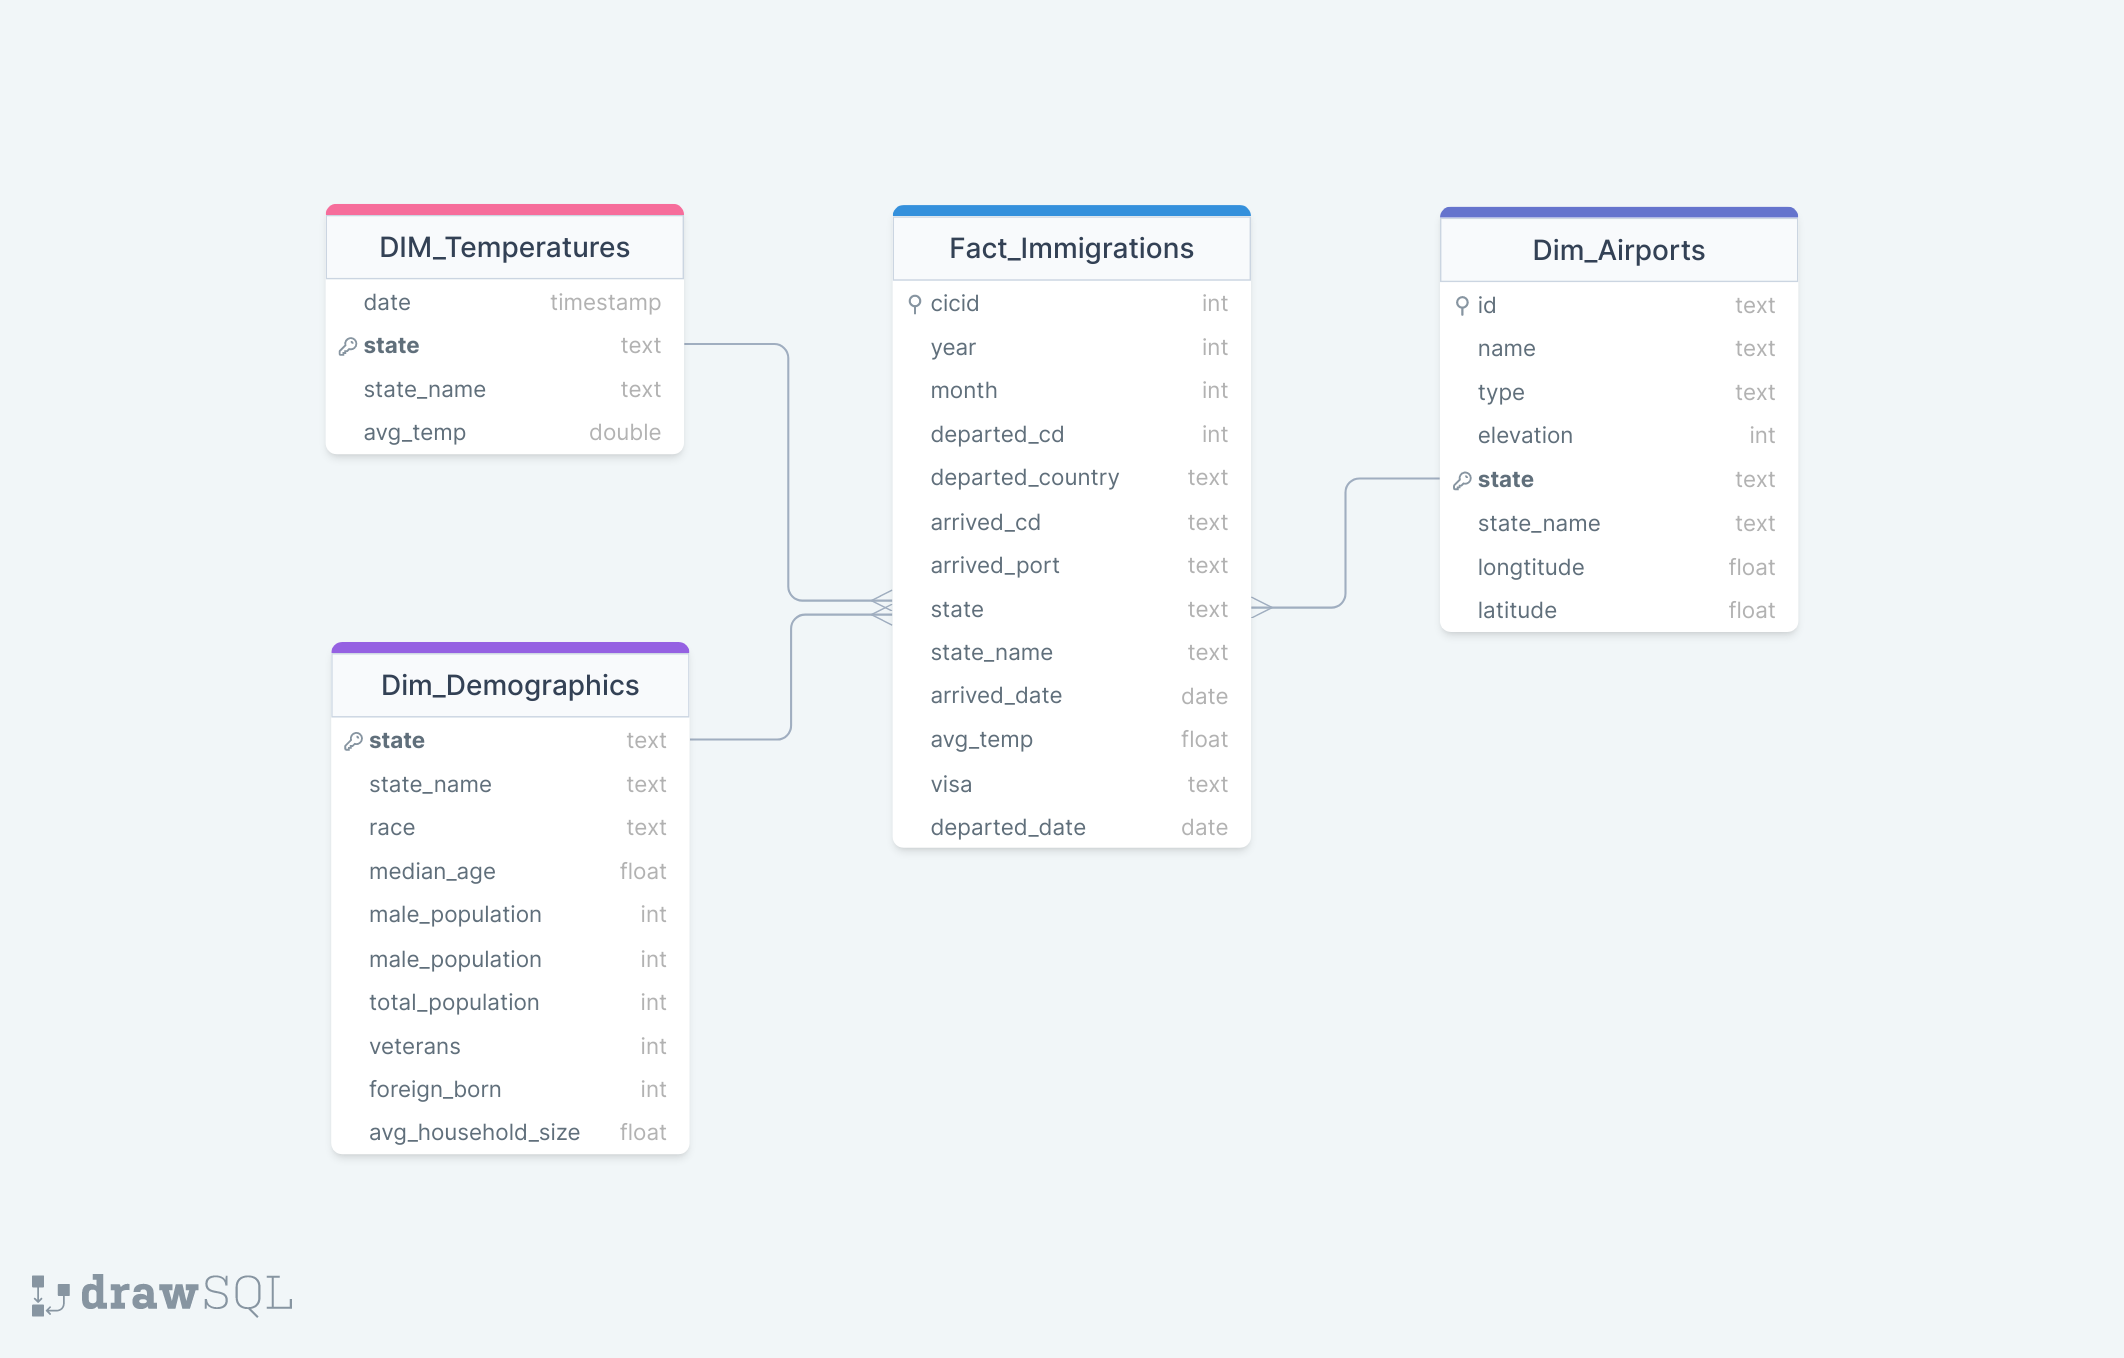

In [22]:
from IPython.display import Image
Image(filename='Conceptual Data Model.png')


#### 3.2 Mapping Out Data Pipelines
List the steps necessary to pipeline the data into the chosen data model

##### Extract Temperatures Dataset as Dimension
- Execute a join with Demographics dataset and quantify the temperature by date and State
- Making a calculation average temperture of one day for 2016 by extracting the historical data of 2003 onwards.
  - Example: 01-01-2016 temperature will be calculated from 01-01-2003, 01-01-2004, etc.,..
  
##### Extract Demographics Dataset as Dimension
- Calculate data by State and Race

##### Extract Airports Dataset as Dimension
- Using 'abbrev_state_udf' UDF to acquire State names

##### Extract Immigration Dataset as Fact
- Execute a join with Dim_Temperature data to acquire the temperature of arrival ports in arrived month based on State.

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

In [23]:
# Making dimesion Temperatures Dataset
dim_temperature_df = temp_df \
    .withColumn("month", month("date")) \
    .withColumn("day",dayofmonth("date")) \
    .join(demographic_df, "city") \
    .groupby(["month","day","state_cd","state_name"]) \
    .agg(round(avg("avg_temp"),2).alias("avg_temp")) \
    .select(concat_ws("-",lit("2016"),lpad("month",2,"0"),lpad("day",2,"0")).cast(TimestampType()).alias("date"),col("state_cd").alias("state"),"state_name","avg_temp")

In [24]:
dim_temperature_df.limit(5).toPandas()

,date,state,state_name,avg_temp
0,2016-09-01,FL,Florida,27.57
1,2016-07-01,DC,District of Columbia,25.35
2,2016-11-01,NJ,New Jersey,7.08
3,2016-06-01,WI,Wisconsin,18.89
4,2016-07-01,OH,Ohio,24.21


In [25]:
dim_temperature_df.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- state: string (nullable = true)
 |-- state_name: string (nullable = true)
 |-- avg_temp: double (nullable = true)



In [26]:
# Making dimesion Demographics Dataset
dim_demographic_df = demographic_df.groupby(["state_cd","state_name","race"]).agg( \
        round(avg("median_age"),2).alias("median_age"), \
        sum("male_population").alias("male_population"), \
        sum("female_population").alias("female_population"), \
        sum("total_population").alias("total_population"), \
        sum("veterans").alias("veterans"), \
        sum("foreign_born").alias("foreign_born"), \
        round(avg("avg_household_size"),2).alias("avg_household_size")) \
    .withColumnRenamed("state_cd","state")

In [27]:
dim_demographic_df.limit(5).toPandas()

,state,state_name,race,median_age,male_population,female_population,total_population,veterans,foreign_born,avg_household_size
0,FL,Florida,Black or African-American,36.90,474878,518088,992966,45267.0,286690.0,3.24
1,IL,Illinois,White,34.13,113443,123977,237420,7811.0,51878.0,2.42
2,MN,Minnesota,White,36.85,69625,77906,147531,6449.0,25135.0,2.75
3,OR,Oregon,American Indian and Alaska Native,36.00,364442,370105,734547,36565.0,105572.0,2.56
4,PR,Puerto Rico,Asian,38.10,30799,35782,66581,NaN,NaN,NaN


In [28]:
dim_demographic_df.printSchema()

root
 |-- state: string (nullable = true)
 |-- state_name: string (nullable = true)
 |-- race: string (nullable = true)
 |-- median_age: double (nullable = true)
 |-- male_population: long (nullable = true)
 |-- female_population: long (nullable = true)
 |-- total_population: long (nullable = true)
 |-- veterans: long (nullable = true)
 |-- foreign_born: long (nullable = true)
 |-- avg_household_size: double (nullable = true)



In [30]:
# Making dimesion Airports Dataset
dim_airport_df = airport_df.filter((col('state').isin(list(abbrev_state_list.keys())))) \
                .withColumn("state_name",abbrev_state_udf(col("state"))).select('id', 'name', 'type', 'elevation', 'state', 'state_name', 'latitude', 'longitude')

In [31]:
dim_airport_df.limit(5).toPandas()

,id,name,type,elevation,state,state_name,latitude,longitude
0,00AA,Aero B Ranch Airport,small_airport,3435,KS,Kansas,38.704021,-101.473907
1,00AK,Lowell Field,small_airport,450,AK,Alaska,59.949200,-151.695999
2,00AL,Epps Airpark,small_airport,820,AL,Alabama,34.864799,-86.770302
3,00AS,Fulton Airport,small_airport,1100,OK,Oklahoma,34.942802,-97.818016
4,00AZ,Cordes Airport,small_airport,3810,AZ,Arizona,34.305599,-112.165001


In [32]:
dim_airport_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- type: string (nullable = true)
 |-- elevation: integer (nullable = true)
 |-- state: string (nullable = true)
 |-- state_name: string (nullable = true)
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)



In [33]:
# Making Fact data of Immigration
fact_immigration_df = immigration_df \
    .join(dim_temperature_df, (immigration_df.state == dim_temperature_df.state) & (trunc("arrived_date","mon") == col("date")), "left") \
    .select("cicid","year","month","departed_cd","departed_country","arrived_cd","arrived_port",immigration_df.state,immigration_df.state_name,"arrived_date","avg_temp","visa","departed_date")

In [34]:
fact_immigration_df.limit(5).toPandas()

,cicid,year,month,departed_cd,departed_country,arrived_cd,arrived_port,state,state_name,arrived_date,avg_temp,visa,departed_date
0,963270,2016,3,209,JAPAN,WAS,WASHINGTON DC,FL,Florida,2016-03-06,19.84,Business,2016-03-17
1,963271,2016,3,209,JAPAN,WAS,WASHINGTON DC,FL,Florida,2016-03-06,19.84,Pleasure,2016-03-09
2,963272,2016,3,209,JAPAN,WAS,WASHINGTON DC,FL,Florida,2016-03-06,19.84,Pleasure,2016-03-10
3,963273,2016,3,209,JAPAN,WAS,WASHINGTON DC,FL,Florida,2016-03-06,19.84,Pleasure,2016-03-10
4,963274,2016,3,209,JAPAN,WAS,WASHINGTON DC,FL,Florida,2016-03-06,19.84,Pleasure,2016-03-10


In [35]:
fact_immigration_df.printSchema()

root
 |-- cicid: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- departed_cd: integer (nullable = true)
 |-- departed_country: string (nullable = true)
 |-- arrived_cd: string (nullable = true)
 |-- arrived_port: string (nullable = true)
 |-- state: string (nullable = true)
 |-- state_name: string (nullable = true)
 |-- arrived_date: string (nullable = true)
 |-- avg_temp: double (nullable = true)
 |-- visa: string (nullable = true)
 |-- departed_date: string (nullable = true)



##### Write dim tables & fact table into parquet
- Dimesion tables dataset is getting snapshot every time due to a small number of updating.
- Dimension Airports dataset is paritioned by State
- Fact Immigration table is getting incremental mode by everytime due to a big number of updating. 
- Fact Immigration dataset is partitioned by Year, Month and State

In [36]:
# Writing dataset
dim_temperature_df.write.mode("overwrite").parquet("output/dim_temperatures")
dim_demographic_df.write.mode("overwrite").parquet("output/dim_demographics")
dim_airport_df.write.mode("overwrite").partitionBy('state').parquet("output/dim_airports")
fact_immigration_df.write.mode("append").partitionBy('year','month','state').parquet("output/fact_immigrations")

#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

In [4]:
# Read written parquet files for data quality check
QC_temperature_df = spark.read.parquet("output/dim_temperatures")
QC_demographics_df =  spark.read.parquet("output/dim_demographics")
QC_airport_df = spark.read.parquet("output/dim_airports")
QC_immigration_df = spark.read.parquet("output/fact_immigrations")

In [5]:
# Checking for zero record in dataset
def QC_zero_record(dfs_name):
    for df_name, df in dfs_name.items():
        row_count = df.count()
        if row_count == 0:
            print(f"FAILED: {df_name} with zero record!")
        else:
            print(f"PASSED: {df_name} with {row_count:,} records.")

In [6]:
# Store all dataframe into a dictionary for the iteration check
dfs_name = {
    'temperature_dim': QC_temperature_df,
    'demographics_dim': QC_demographics_df,
    'airport_dim': QC_airport_df,
    'immigration_fact': QC_immigration_df
}

In [7]:
# Count data rows of each dataframe
QC_zero_record(dfs_name)

PASSED: temperature_dim with 504 records.
PASSED: demographics_dim with 174 records.
PASSED: airport_dim with 14,575 records.
PASSED: immigration_fact with 36,159,930 records.


In [18]:
# create view for all tables (to use spark sql in next step)
def create_view_from_df(dfs_name):
    for df_name, df in dfs_name.items():
        df.createOrReplaceTempView("{}".format(df_name))

create_view_from_df(dfs_name)

In [12]:
# Make a fuction to check null data
def QC_column_null(spark, columns_mapping):
    print("QC check for null columns:")
    
    for view in columns_mapping:
        for column in columns_mapping[view]:
            querry_info = spark.sql(f"""SELECT COUNT(*) as record_nums FROM {view}""")
            if querry_info.head()[0] == 0:
                print(f"Found NULL values in column {column} of view {view}")
                
        print(f"{view}: Passed")

In [13]:
# A dictionary of tables and columns to be checked
columns_mapping = {
    'temperature_dim' :['state','date','avg_temp'],
    'demographics_dim' :['state', 'race'],
    'airport_dim': ['id', 'state'],
    'immigration_fact': ['cicid','year','month','departed_cd','arrived_cd','arrived_date']
    }

In [14]:
# Check null data in dataset
QC_column_null(spark, columns_mapping)

QC check for null columns:
temperature_dim: Passed
demographics_dim: Passed
airport_dim: Passed
immigration_fact: Passed


### Run query to answer analytic questions

In [23]:
# Which 5 countries has the most people coming to the New York State on Xmas Eve 2016?
sample_query_1 = spark.sql("""
    WITH CTE_1 AS (
        SELECT departed_country, count(*) as people_count
        FROM immigration_fact
        WHERE state = 'NY' AND arrived_date = '2016-12-24'
        GROUP BY departed_country
    )
    SELECT departed_country, people_count
    FROM CTE_1
    ORDER BY people_count DESC
    LIMIT 5
""")

sample_query_1.limit(5).toPandas()

,departed_country,people_count
0,FRANCE,1937
1,ITALY,1931
2,UNITED KINGDOM,1898
3,SPAIN,1196
4,"CHINA, PRC",1101


In [25]:
# Top 3 months when the most people go to New York State?
sample_query_2 = spark.sql("""
    WITH CTE_1 AS (
        SELECT *
        FROM immigration_fact
        WHERE state = 'NY'        
    ),
    CTE_2 AS (
        SELECT month, count(*) as people_count
        FROM CTE_1
        GROUP BY month
    )
    SELECT month, people_count
    FROM CTE_2
    ORDER BY people_count DESC
    LIMIT 3
""")
sample_query_2.limit(3).toPandas()

,month,people_count
0,8,659214
1,10,656882
2,7,655930


In [71]:
# Top 5 arrival states and their total_population
sample_query_3 = spark.sql("""
    WITH CTE AS (
    SELECT immigration_fact.state_name as state_name, immigration_fact.state as state_key, count(*) as people_count
    FROM immigration_fact 
    GROUP BY immigration_fact.state_name, immigration_fact.state
    ORDER BY people_count DESC
    LIMIT 5),
    
    CTE_2 AS (
    SELECT CTE.state_name, people_count, total_population, RANK () OVER (PARTITION BY CTE.state_name ORDER BY total_population DESC) AS ranking
    FROM CTE LEFT JOIN demographics_dim
    on CTE.state_key =  demographics_dim.state
    ORDER BY people_count)
    
    SELECT state_name, people_count, total_population
    FROM CTE_2
    WHERE ranking=1
    ORDER BY people_count DESC
    
""")
sample_query_3.toPandas()

,state_name,people_count,total_population
0,Texas,1626820,4042606
1,Hawaii,2315748,352766
2,California,6414761,9863271
3,New York,6526484,8706318
4,Florida,8077763,2695643


#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

#### Fact Table
 **Immigration**
- cicid (integer) - ID
- year (integer) -  Immigration year
- month (integer) - Immigration month
- departed_cd (integer) - Departed Country Code 
- departed_country (string) -  Departed Country Name
- arrived_cd (string) - Arrival port code
- arrived_port (string) - Arrival port name
- state (string) - State Code of Port
- state_name (string) - State Name
- arrived_date (timestamp) - Arrival Date
- avg_temp (double) - Average Temperatures 
- visa (string) - Visa type
- departed_date (timestamp) - Departed date

#### Dimension Tables
**Temperatures**
- date (timestamp) - Date of average temperature
- state (string) - State Code
- state_name (string) - State Name
- avg_temp (double) - Average temperature
 
**Demographics**
 - state (string) - State Code
 - state_name (string) - State Name
 - race: (string) - Human race
 - median_age (double) - State's Median Age
 - male_population (long) - State's Male Population 
 - female_population (long) - State's Female Population
 - total_population (long) - State's Total Population
 - veterans (long) - State's number veterans
 - foreign_born (long) - State's Foreign Born
 - avg_household_size (double) - State's Average Household Size
 
**Airports**
- id (string) - ID
- name (string) - Airport's name
- type (string) - Aiport's type (small, large, medium)
- elevation (string) - airpot's elevation (ft)
- state (string) - Code of State in which aiport located
- state_name (string) - State name
- latitude (float) - Airpot's Latitude
- longitude (float) - Airpot's Longitude


#### Step 5: Complete Project Write Up

##### Clearly state the rationale for the choice of tools and technologies for the project.

- I choose Apache Spark for this project because of its powerful of distributed system to process a big number of data (more than 30mil rows of fact table) and the SparkSQL become handy for wide range of usage from multiple user to check the analytic queries and perform very fast without any problem.

##### Propose how often the data should be updated and why.
- Dim Temperature is updated daily to get the newest everyday 
- Dim Airports and demographics are not changing frequently so they can be updated quarterly 
- Fact Immigration table should be updated daily withn incremental mode (append new rows) into existed dataset. 


##### Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 
 > Spark and SparkSQL is still manageable of the 100 times size bigger compared to the current ones. For better experienced analysis and real-time monitoring, system can add more cluster nodes on cloud computing services in AWS such as Amazon EMR, AWS Glue.
 
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 
 > Airflow can be handle to set the schedule of updating on daily basis by 7am.
 
 * The database needed to be accessed by 100+ people.
 > Utilizing more cloud computing to serve more people at the same time. Staging the data into AWS S3 as a data lake storage and ETL into AWS Redshift with the good settings on sever cloud computing.